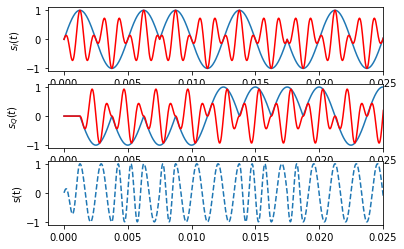

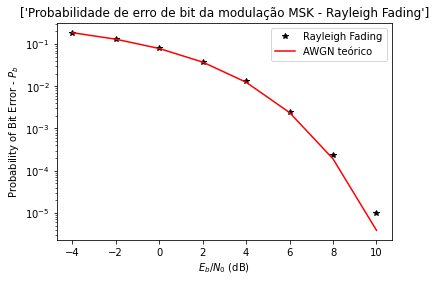

In [ ]:
#modulação msk com rayleigh fading

from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
#funções retiradas de Digital Comunications with Python
def awgn(s,SNRdB,L=1):   #canal awgn
    """
    AWGN channel
    
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB)
            for the received signal
        L : oversampling factor (applicable for waveform simulation)
            default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #SNR to linear scale
    
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
        
    N0=P/gamma # Find the noise spectral density    
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal    
    return r

def rayleighFading(N): #canal rayleigh fading
    """
    Generate Rayleigh flat-fading channel samples
    Parameters:
        N : number of samples to generate
    Returns:
        abs_h : Rayleigh flat fading samples
    """
    # 1 tap complex gaussian filter
    h = 1/sqrt(2)*(standard_normal(N)+1j*standard_normal(N))
    return h

import numpy as np
import matplotlib.pyplot as plt
def msk_mod(a, fc, OF, enable_plot = False):         #modulação msk
    """
    Modulate an incoming binary stream using MSK
    Parameters:
        a : input binary data stream (0's and 1's) to modulate
        fc : carrier frequency in Hertz
        OF : oversampling factor (at least 4 is better)
    Returns:
        result : Dictionary containing the following keyword entries:
          s(t) : MSK modulated signal with carrier
          sI(t) : baseband I channel waveform(no carrier)
          sQ(t) : baseband Q channel waveform(no carrier)
          t: time base
    """ 
    ak = 2*a-1 # NRZ encoding 0-> -1, 1->+1
    ai = ak[0::2]; aq = ak[1::2] # split even and odd bit streams
    L = 2*OF # represents one symbol duration Tsym=2xTb
    
    #upsample by L the bits streams in I and Q arms
    from scipy.signal import upfirdn, lfilter
    ai = upfirdn(h=[1], x=ai, up = L)
    aq = upfirdn(h=[1], x=aq, up = L)
    
    aq = np.pad(aq, (L//2,0), 'constant') # delay aq by Tb (delay by L/2)
    ai = np.pad(ai, (0,L//2), 'constant') # padding at end to equal length of Q
    
    #construct Low-pass filter and filter the I/Q samples through it
    Fs = OF*fc;Ts = 1/Fs;Tb = OF*Ts
    t = np.arange(0,2*Tb+Ts,Ts)
    h = np.sin(np.pi*t/(2*Tb))# LPF filter
    sI_t = lfilter(b = h, a = [1], x = ai) # baseband I-channel
    sQ_t = lfilter(b = h, a = [1], x = aq) # baseband Q-channel
    
    t=np.arange(0, Ts*len(sI_t), Ts) # for RF carrier
    sIc_t = sI_t*np.cos(2*np.pi*fc*t) #with carrier
    sQc_t = sQ_t*np.sin(2*np.pi*fc*t) #with carrier
    s_t =  sIc_t - sQc_t# Bandpass MSK modulated signal
    
    if enable_plot:
        fig, (ax1,ax2,ax3) = plt.subplots(3, 1)
        
        ax1.plot(t,sI_t);ax1.plot(t,sIc_t,'r')
        ax2.plot(t,sQ_t);ax2.plot(t,sQc_t,'r')
        ax3.plot(t,s_t,'--')        
        ax1.set_ylabel('$s_I(t)$');ax2.set_ylabel('$s_Q(t)$')
        ax3.set_ylabel('s(t)')        
        ax1.set_xlim([-Tb,20*Tb]);ax2.set_xlim([-Tb,20*Tb])
        ax3.set_xlim([-Tb,20*Tb])
        fig.show()
        
    result = dict()
    result['s(t)']=s_t;result['sI(t)']=sI_t;result['sQ(t)']=sQ_t;result['t']=t
    return result

def msk_demod(r,N,fc,OF): #demodulação msk
    """
    MSK demodulator
    Parameters:
        r : received signal at the receiver front end
        N : number of symbols transmitted
        fc : carrier frequency in Hertz
        OF : oversampling factor (at least 4 is better)
    Returns:
        a_hat : detected binary stream
    """
    L = 2*OF # samples in 2Tb duration
    Fs=OF*fc;Ts=1/Fs;Tb = OF*Ts; # sampling frequency, durations
    t=np.arange(-OF, len(r) - OF)/Fs # time base
    
    # cosine and sine functions for half-sinusoid shaping
    x=abs(np.cos(np.pi*t/(2*Tb)));y=abs(np.sin(np.pi*t/(2*Tb)))
    
    u=r*x*np.cos(2*np.pi*fc*t) # multiply I by half cosines and cos(2pifct)
    v=-r*y*np.sin(2*np.pi*fc*t) # multiply Q by half sines and sin(2pifct)
    
    iHat = np.convolve(u,np.ones(L)) # integrate for L (Tsym=2*Tb) duration
    qHat = np.convolve(v,np.ones(L)) # integrate for L (Tsym=2*Tb) duration
    
    iHat= iHat[L-1:-1-L:L]  # I- sample at the end of every symbol
    qHat= qHat[L+L//2-1:-1-L//2:L] # Q-sample from L+L/2th sample
    a_hat = np.zeros(N)
    a_hat[0::2][0:-1] = iHat > 0 # thresholding - odd bits
    a_hat[1::2][0:-1] = qHat > 0 # thresholding - even bits
    
    return a_hat

from scipy.special import erfc
N = 100000 # numero de símbolos a transmitir
EbN0dB = np.arange(start=-4,stop = 11,step = 2) # range eb/n0 pra transmitir
fc = 800 # frequencia de portadora
OF = 32 # fator de oversampling
BER = np.zeros(len(EbN0dB)) # valores de ber pra cada eb/n0
a = np.random.randint(2, size=N) # símbolos entre 0 e 1
result = msk_mod(a,fc,OF,enable_plot=True) # modulação MSK
s = result['s(t)']
for i,EbN0 in enumerate(EbN0dB):
# computar e adicionar ruído AWGN
    h = rayleighFading(1) #canal rayleigh fading
    r = awgn(h*s,EbN0,OF) # adicionando AWGN ao sinal
    r = h.conj()/abs(h) ** 2 * r   #equalizador LS
    a_hat = msk_demod(r,N,fc,OF) #receptor
    BER[i] = np.sum(a!=a_hat)/N # computação da BER
theoreticalBER = 0.5*erfc(np.sqrt(10**(EbN0dB/10))) # Taxa de erro de bits teórica
#-------------Plots---------------------------
fig, ax = plt.subplots(nrows=1,ncols = 1)
ax.semilogy(EbN0dB,BER,'k*',label='Rayleigh Fading') # BER simulada
ax.semilogy(EbN0dB,theoreticalBER,'r-',label='AWGN teórico')
ax.set_xlabel(r'$E_b/N_0$ (dB)')
ax.set_ylabel(r'Probability of Bit Error - $P_b$')
ax.set_title(['Probabilidade de erro de bit da modulação MSK - Rayleigh Fading'])
ax.legend();fig.show();

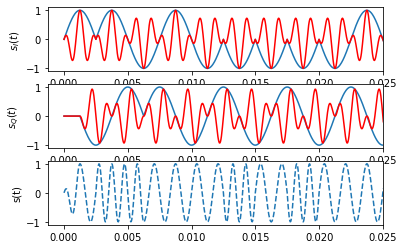

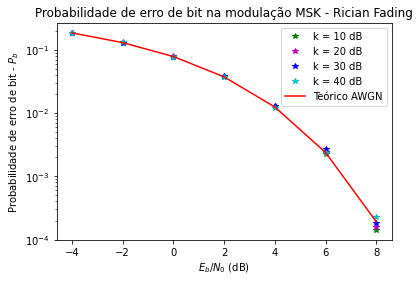

In [12]:
#modulação msk com rician fading

from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal

def awgn(s,SNRdB,L=1):         #canal awgn
    """
    AWGN channel
    
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB)
            for the received signal
        L : oversampling factor (applicable for waveform simulation)
            default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #escala snr pra linear
    
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
        
    N0=P/gamma # Find the noise spectral density    
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal    
    return r

def ricianFading(K_dB,N):           #canal rician fading
    """
    Generate Rician flat-fading channel samples
    Parameters:
        K_dB: Rician K factor in dB scale
        N : number of samples to generate
    Returns:
        abs_h : Rician flat fading samples
    """
    K = 10**(K_dB/10) # K factor in linear scale
    mu = sqrt(K/(2*(K+1))) # mean
    sigma = sqrt(1/(2*(K+1))) # sigma
    h = (sigma*standard_normal(N)+mu)+1j*(sigma*standard_normal(N)+mu)
    return abs(h)

import numpy as np
import matplotlib.pyplot as plt
def msk_mod(a, fc, OF, enable_plot = False):    #modulação msk
    """
    Modulate an incoming binary stream using MSK
    Parameters:
        a : input binary data stream (0's and 1's) to modulate
        fc : carrier frequency in Hertz
        OF : oversampling factor (at least 4 is better)
    Returns:
        result : Dictionary containing the following keyword entries:
          s(t) : MSK modulated signal with carrier
          sI(t) : baseband I channel waveform(no carrier)
          sQ(t) : baseband Q channel waveform(no carrier)
          t: time base
    """ 
    ak = 2*a-1 # NRZ encoding 0-> -1, 1->+1
    ai = ak[0::2]; aq = ak[1::2] # split even and odd bit streams
    L = 2*OF # represents one symbol duration Tsym=2xTb
    
    #upsample by L the bits streams in I and Q arms
    from scipy.signal import upfirdn, lfilter
    ai = upfirdn(h=[1], x=ai, up = L)
    aq = upfirdn(h=[1], x=aq, up = L)
    
    aq = np.pad(aq, (L//2,0), 'constant') # delay aq by Tb (delay by L/2)
    ai = np.pad(ai, (0,L//2), 'constant') # padding at end to equal length of Q
    
    #construct Low-pass filter and filter the I/Q samples through it
    Fs = OF*fc;Ts = 1/Fs;Tb = OF*Ts
    t = np.arange(0,2*Tb+Ts,Ts)
    h = np.sin(np.pi*t/(2*Tb))# LPF filter
    sI_t = lfilter(b = h, a = [1], x = ai) # baseband I-channel
    sQ_t = lfilter(b = h, a = [1], x = aq) # baseband Q-channel
    
    t=np.arange(0, Ts*len(sI_t), Ts) # for RF carrier
    sIc_t = sI_t*np.cos(2*np.pi*fc*t) #with carrier
    sQc_t = sQ_t*np.sin(2*np.pi*fc*t) #with carrier
    s_t =  sIc_t - sQc_t# Bandpass MSK modulated signal
    
    if enable_plot:
        fig, (ax1,ax2,ax3) = plt.subplots(3, 1)
        
        ax1.plot(t,sI_t);ax1.plot(t,sIc_t,'r')
        ax2.plot(t,sQ_t);ax2.plot(t,sQc_t,'r')
        ax3.plot(t,s_t,'--')        
        ax1.set_ylabel('$s_I(t)$');ax2.set_ylabel('$s_Q(t)$')
        ax3.set_ylabel('s(t)')        
        ax1.set_xlim([-Tb,20*Tb]);ax2.set_xlim([-Tb,20*Tb])
        ax3.set_xlim([-Tb,20*Tb])
        fig.show()
        
    result = dict()
    result['s(t)']=s_t;result['sI(t)']=sI_t;result['sQ(t)']=sQ_t;result['t']=t
    return result

def msk_demod(r,N,fc,OF):         #demodulação msk
    """
    MSK demodulator
    Parameters:
        r : received signal at the receiver front end
        N : number of symbols transmitted
        fc : carrier frequency in Hertz
        OF : oversampling factor (at least 4 is better)
    Returns:
        a_hat : detected binary stream
    """
    L = 2*OF # samples in 2Tb duration
    Fs=OF*fc;Ts=1/Fs;Tb = OF*Ts; # sampling frequency, durations
    t=np.arange(-OF, len(r) - OF)/Fs # time base
    
    # cosine and sine functions for half-sinusoid shaping
    x=abs(np.cos(np.pi*t/(2*Tb)));y=abs(np.sin(np.pi*t/(2*Tb)))
    
    u=r*x*np.cos(2*np.pi*fc*t) # multiply I by half cosines and cos(2pifct)
    v=-r*y*np.sin(2*np.pi*fc*t) # multiply Q by half sines and sin(2pifct)
    
    iHat = np.convolve(u,np.ones(L)) # integrate for L (Tsym=2*Tb) duration
    qHat = np.convolve(v,np.ones(L)) # integrate for L (Tsym=2*Tb) duration
    
    iHat= iHat[L-1:-1-L:L]  # I- sample at the end of every symbol
    qHat= qHat[L+L//2-1:-1-L//2:L] # Q-sample from L+L/2th sample
    a_hat = np.zeros(N)
    a_hat[0::2][0:-1] = iHat > 0 # thresholding - odd bits
    a_hat[1::2][0:-1] = qHat > 0 # thresholding - even bits
    
    return a_hat

from scipy.special import erfc
N = 100000 # Número de símbolos pra transmitir
EbN0dB = np.arange(start=-4,stop = 9,step = 2) # range eb/n0 pra simulação
fc = 800 # frequência da portadora
OF = 32 # fator de oversampling
BER = np.zeros(len(EbN0dB)) # valores de ber pra cada eb/n0
a = np.random.randint(2, size=N) # símbolos 0 ou 1
result = msk_mod(a,fc,OF,enable_plot=True) # modulação msk
s = result['s(t)']                     #computando o sinal transmitido
pointcolors=['g*','m*','b*','c*']      #cores para os múltiplos plots da rician fading
fig, ax = plt.subplots(nrows=1,ncols = 1)
for j,k_db in enumerate([10,20,30,40]):
  for i,EbN0 in enumerate(EbN0dB):
# Compute and add AWGN noise
      h = ricianFading(k_db,1)               #canal rician fading com K variável
      r = awgn(h*s,EbN0,OF)                  #awgn somado ao sinal 
      r = h.conj()/abs(h) ** 2 * r           #equalizador LS
      a_hat = msk_demod(r,N,fc,OF)           #demodulação msk (receptor)
      BER[i] = np.sum(a!=a_hat)/N            # computação BER
      label = 'k = '+ str(k_db) +' dB'
  ax.semilogy(EbN0dB,BER,pointcolors[j],label=label) # plot BER pra cada K
theoreticalBER = 0.5*erfc(np.sqrt(10**(EbN0dB/10))) # BER teórica pra AWGN pra comparação
#-------------Plots---------------------------
#fig, ax = plt.subplots(nrows=1,ncols = 1)
#ax.semilogy(EbN0dB,BER,'k*',label='Simulated') # simulated BER
ax.semilogy(EbN0dB,theoreticalBER,'r-',label='Teórico AWGN')         #plot ber awgn

ax.set_xlabel(r'$E_b/N_0$ (dB)')
ax.set_ylabel(r'Probabilidade de erro de bit - $P_b$')
ax.set_title('Probabilidade de erro de bit na modulação MSK - Rician Fading')
ax.legend();fig.show();

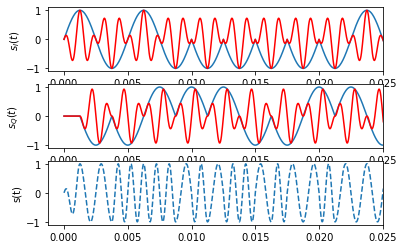

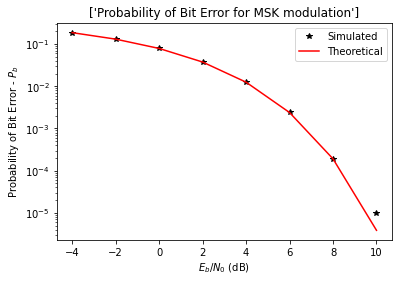

In [2]:
#modulação msk com awgn

from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal

def awgn(s,SNRdB,L=1):
    """
    AWGN channel
    
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB)
            for the received signal
        L : oversampling factor (applicable for waveform simulation)
            default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #SNR to linear scale
    
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
        
    N0=P/gamma # Find the noise spectral density    
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal    
    return r

def rayleighFading(N):
    """
    Generate Rayleigh flat-fading channel samples
    Parameters:
        N : number of samples to generate
    Returns:
        abs_h : Rayleigh flat fading samples
    """
    # 1 tap complex gaussian filter
    h = 1/sqrt(2)*(standard_normal(N)+1j*standard_normal(N))
    return h

def ricianFading(K_dB,N):
    """
    Generate Rician flat-fading channel samples
    Parameters:
        K_dB: Rician K factor in dB scale
        N : number of samples to generate
    Returns:
        abs_h : Rician flat fading samples
    """
    K = 10**(K_dB/10) # K factor in linear scale
    mu = sqrt(K/(2*(K+1))) # mean
    sigma = sqrt(1/(2*(K+1))) # sigma
    h = (sigma*standard_normal(N)+mu)+1j*(sigma*standard_normal(N)+mu)
    return abs(h)

import numpy as np
import matplotlib.pyplot as plt
def msk_mod(a, fc, OF, enable_plot = False):
    """
    Modulate an incoming binary stream using MSK
    Parameters:
        a : input binary data stream (0's and 1's) to modulate
        fc : carrier frequency in Hertz
        OF : oversampling factor (at least 4 is better)
    Returns:
        result : Dictionary containing the following keyword entries:
          s(t) : MSK modulated signal with carrier
          sI(t) : baseband I channel waveform(no carrier)
          sQ(t) : baseband Q channel waveform(no carrier)
          t: time base
    """ 
    ak = 2*a-1 # NRZ encoding 0-> -1, 1->+1
    ai = ak[0::2]; aq = ak[1::2] # split even and odd bit streams
    L = 2*OF # represents one symbol duration Tsym=2xTb
    
    #upsample by L the bits streams in I and Q arms
    from scipy.signal import upfirdn, lfilter
    ai = upfirdn(h=[1], x=ai, up = L)
    aq = upfirdn(h=[1], x=aq, up = L)
    
    aq = np.pad(aq, (L//2,0), 'constant') # delay aq by Tb (delay by L/2)
    ai = np.pad(ai, (0,L//2), 'constant') # padding at end to equal length of Q
    
    #construct Low-pass filter and filter the I/Q samples through it
    Fs = OF*fc;Ts = 1/Fs;Tb = OF*Ts
    t = np.arange(0,2*Tb+Ts,Ts)
    h = np.sin(np.pi*t/(2*Tb))# LPF filter
    sI_t = lfilter(b = h, a = [1], x = ai) # baseband I-channel
    sQ_t = lfilter(b = h, a = [1], x = aq) # baseband Q-channel
    
    t=np.arange(0, Ts*len(sI_t), Ts) # for RF carrier
    sIc_t = sI_t*np.cos(2*np.pi*fc*t) #with carrier
    sQc_t = sQ_t*np.sin(2*np.pi*fc*t) #with carrier
    s_t =  sIc_t - sQc_t# Bandpass MSK modulated signal
    
    if enable_plot:
        fig, (ax1,ax2,ax3) = plt.subplots(3, 1)
        
        ax1.plot(t,sI_t);ax1.plot(t,sIc_t,'r')
        ax2.plot(t,sQ_t);ax2.plot(t,sQc_t,'r')
        ax3.plot(t,s_t,'--')        
        ax1.set_ylabel('$s_I(t)$');ax2.set_ylabel('$s_Q(t)$')
        ax3.set_ylabel('s(t)')        
        ax1.set_xlim([-Tb,20*Tb]);ax2.set_xlim([-Tb,20*Tb])
        ax3.set_xlim([-Tb,20*Tb])
        fig.show()
        
    result = dict()
    result['s(t)']=s_t;result['sI(t)']=sI_t;result['sQ(t)']=sQ_t;result['t']=t
    return result

def msk_demod(r,N,fc,OF):
    """
    MSK demodulator
    Parameters:
        r : received signal at the receiver front end
        N : number of symbols transmitted
        fc : carrier frequency in Hertz
        OF : oversampling factor (at least 4 is better)
    Returns:
        a_hat : detected binary stream
    """
    L = 2*OF # samples in 2Tb duration
    Fs=OF*fc;Ts=1/Fs;Tb = OF*Ts; # sampling frequency, durations
    t=np.arange(-OF, len(r) - OF)/Fs # time base
    
    # cosine and sine functions for half-sinusoid shaping
    x=abs(np.cos(np.pi*t/(2*Tb)));y=abs(np.sin(np.pi*t/(2*Tb)))
    
    u=r*x*np.cos(2*np.pi*fc*t) # multiply I by half cosines and cos(2pifct)
    v=-r*y*np.sin(2*np.pi*fc*t) # multiply Q by half sines and sin(2pifct)
    
    iHat = np.convolve(u,np.ones(L)) # integrate for L (Tsym=2*Tb) duration
    qHat = np.convolve(v,np.ones(L)) # integrate for L (Tsym=2*Tb) duration
    
    iHat= iHat[L-1:-1-L:L]  # I- sample at the end of every symbol
    qHat= qHat[L+L//2-1:-1-L//2:L] # Q-sample from L+L/2th sample
    a_hat = np.zeros(N)
    a_hat[0::2][0:-1] = iHat > 0 # thresholding - odd bits
    a_hat[1::2][0:-1] = qHat > 0 # thresholding - even bits
    
    return a_hat

from scipy.special import erfc
from scipy.signal import lfilter
N = 100000 # numero de símbolos a transmitir
EbN0dB = np.arange(start=-4,stop = 11,step = 2) # range eb/n0 pra simulação
fc = 800 # frequência da portadora
OF = 32 # fator de oversampling
BER = np.zeros(len(EbN0dB)) # valores de ber pra cada eb/n0
a = np.random.randint(2, size=N) # símbolos entre 0 e 1
result = msk_mod(a,fc,OF,enable_plot=True) # modulação MSK
s = result['s(t)']
for i,EbN0 in enumerate(EbN0dB):
# Compute and add AWGN noise
    r = awgn(s,EbN0,OF) # canal awgn
    a_hat = msk_demod(r,N,fc,OF) #receptor demodulação msk
    BER[i] = np.sum(a!=a_hat)/N # computação da ber
theoreticalBER = 0.5*erfc(np.sqrt(10**(EbN0dB/10))) # ber teórica
#-------------Plots---------------------------
fig, ax = plt.subplots(nrows=1,ncols = 1)
ax.semilogy(EbN0dB,BER,'k*',label='Simulated') # simulated BER
ax.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
ax.set_xlabel(r'$E_b/N_0$ (dB)')
ax.set_ylabel(r'Probability of Bit Error - $P_b$')
ax.set_title(['Probability of Bit Error for MSK modulation'])
ax.legend();fig.show();


In [ ]:
#modulação msk com canal de filtro FIR - Em progresso

from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal

def awgn(s,SNRdB,L=1):
    """
    AWGN channel
    
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB)
            for the received signal
        L : oversampling factor (applicable for waveform simulation)
            default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #SNR to linear scale
    
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
        
    N0=P/gamma # Find the noise spectral density    
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal    
    return r

def rayleighFading(N):
    """
    Generate Rayleigh flat-fading channel samples
    Parameters:
        N : number of samples to generate
    Returns:
        abs_h : Rayleigh flat fading samples
    """
    # 1 tap complex gaussian filter
    h = 1/sqrt(2)*(standard_normal(N)+1j*standard_normal(N))
    return h

def ricianFading(K_dB,N):
    """
    Generate Rician flat-fading channel samples
    Parameters:
        K_dB: Rician K factor in dB scale
        N : number of samples to generate
    Returns:
        abs_h : Rician flat fading samples
    """
    K = 10**(K_dB/10) # K factor in linear scale
    mu = sqrt(K/(2*(K+1))) # mean
    sigma = sqrt(1/(2*(K+1))) # sigma
    h = (sigma*standard_normal(N)+mu)+1j*(sigma*standard_normal(N)+mu)
    return abs(h)

import numpy as np
import matplotlib.pyplot as plt
def msk_mod(a, fc, OF, enable_plot = False):
    """
    Modulate an incoming binary stream using MSK
    Parameters:
        a : input binary data stream (0's and 1's) to modulate
        fc : carrier frequency in Hertz
        OF : oversampling factor (at least 4 is better)
    Returns:
        result : Dictionary containing the following keyword entries:
          s(t) : MSK modulated signal with carrier
          sI(t) : baseband I channel waveform(no carrier)
          sQ(t) : baseband Q channel waveform(no carrier)
          t: time base
    """ 
    ak = 2*a-1 # NRZ encoding 0-> -1, 1->+1
    ai = ak[0::2]; aq = ak[1::2] # split even and odd bit streams
    L = 2*OF # represents one symbol duration Tsym=2xTb
    
    #upsample by L the bits streams in I and Q arms
    from scipy.signal import upfirdn, lfilter
    ai = upfirdn(h=[1], x=ai, up = L)
    aq = upfirdn(h=[1], x=aq, up = L)
    
    aq = np.pad(aq, (L//2,0), 'constant') # delay aq by Tb (delay by L/2)
    ai = np.pad(ai, (0,L//2), 'constant') # padding at end to equal length of Q
    
    #construct Low-pass filter and filter the I/Q samples through it
    Fs = OF*fc;Ts = 1/Fs;Tb = OF*Ts
    t = np.arange(0,2*Tb+Ts,Ts)
    h = np.sin(np.pi*t/(2*Tb))# LPF filter
    sI_t = lfilter(b = h, a = [1], x = ai) # baseband I-channel
    sQ_t = lfilter(b = h, a = [1], x = aq) # baseband Q-channel
    
    t=np.arange(0, Ts*len(sI_t), Ts) # for RF carrier
    sIc_t = sI_t*np.cos(2*np.pi*fc*t) #with carrier
    sQc_t = sQ_t*np.sin(2*np.pi*fc*t) #with carrier
    s_t =  sIc_t - sQc_t# Bandpass MSK modulated signal
    
    if enable_plot:
        fig, (ax1,ax2,ax3) = plt.subplots(3, 1)
        
        ax1.plot(t,sI_t);ax1.plot(t,sIc_t,'r')
        ax2.plot(t,sQ_t);ax2.plot(t,sQc_t,'r')
        ax3.plot(t,s_t,'--')        
        ax1.set_ylabel('$s_I(t)$');ax2.set_ylabel('$s_Q(t)$')
        ax3.set_ylabel('s(t)')        
        ax1.set_xlim([-Tb,20*Tb]);ax2.set_xlim([-Tb,20*Tb])
        ax3.set_xlim([-Tb,20*Tb])
        fig.show()
        
    result = dict()
    result['s(t)']=s_t;result['sI(t)']=sI_t;result['sQ(t)']=sQ_t;result['t']=t
    return result

def msk_demod(r,N,fc,OF):
    """
    MSK demodulator
    Parameters:
        r : received signal at the receiver front end
        N : number of symbols transmitted
        fc : carrier frequency in Hertz
        OF : oversampling factor (at least 4 is better)
    Returns:
        a_hat : detected binary stream
    """
    L = 2*OF # samples in 2Tb duration
    Fs=OF*fc;Ts=1/Fs;Tb = OF*Ts; # sampling frequency, durations
    t=np.arange(-OF, len(r) - OF)/Fs # time base
    
    # cosine and sine functions for half-sinusoid shaping
    x=abs(np.cos(np.pi*t/(2*Tb)));y=abs(np.sin(np.pi*t/(2*Tb)))
    
    u=r*x*np.cos(2*np.pi*fc*t) # multiply I by half cosines and cos(2pifct)
    v=-r*y*np.sin(2*np.pi*fc*t) # multiply Q by half sines and sin(2pifct)
    
    iHat = np.convolve(u,np.ones(L)) # integrate for L (Tsym=2*Tb) duration
    qHat = np.convolve(v,np.ones(L)) # integrate for L (Tsym=2*Tb) duration
    
    iHat= iHat[L-1:-1-L:L]  # I- sample at the end of every symbol
    qHat= qHat[L+L//2-1:-1-L//2:L] # Q-sample from L+L/2th sample
    a_hat = np.zeros(N)
    a_hat[0::2][0:-1] = iHat > 0 # thresholding - odd bits
    a_hat[1::2][0:-1] = qHat > 0 # thresholding - even bits
    
    return a_hat

from scipy.special import erfc
from scipy.signal import lfilter,upfirdn
N = 100000 # Number of symbols to transmit
EbN0dB = np.arange(start=-4,stop = 11,step = 2) # Eb/N0 range in dB for simulation
fc = 800 # carrier frequency in Hertz
OF = 32 # oversampling factor, sampling frequency will be fs=OF*fc
BER = np.zeros(len(EbN0dB)) # For BER values for each Eb/N0
a = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
result = msk_mod(a,fc,OF,enable_plot=True) # MSK modulation
s = result['s(t)']
for i,EbN0 in enumerate(EbN0dB):
# Compute and add AWGN noise
    h=upfirdn(h=[1], x=h, up = 64)
    h=lfilter(h,1,s)
    print(h)
    r = awgn(h*s,EbN0,OF) # refer Chapter section 4.
    r = h.conj()/abs(h) ** 2 * r
    a_hat = msk_demod(r,N,fc,OF) #receiver
    BER[i] = np.sum(a!=a_hat)/N # Bit Error Rate Computation
theoreticalBER = 0.5*erfc(np.sqrt(10**(EbN0dB/10))) # Theoretical bit error rate
#-------------Plots---------------------------
fig, ax = plt.subplots(nrows=1,ncols = 1)
ax.semilogy(EbN0dB,BER,'k*',label='Simulated') # simulated BER
ax.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
ax.set_xlabel(r'$E_b/N_0$ (dB)')
ax.set_ylabel(r'Probability of Bit Error - $P_b$')
ax.set_title(['Probability of Bit Error for MSK modulation'])
ax.legend();fig.show();
